In [1]:
# !pip install pandas xarray fastparquet

In [1]:
import glob
from collections import OrderedDict
import pandas as pd
import xarray as xr
from tqdm import tqdm
from pyexeggutor import check_argument_choice

In [4]:
def merge_pathway_profiling_tables_as_xarray(profiling_directory:str, data_type:str, level="genomes", metric="number_of_reads", fillna_with_zeros:bool=False):
    
    """
    merges sample-level {data_type} values from multiple samples into a single DataFrame.

    Parameters
    ----------
    profiling_directory : str
        Path to directory containing sample-level directories with output files.
    data_type : str
        Type of {level}-level data to merge. One of: {"feature_abundances", "feature_prevalence", "feature_prevalence-binary", "feature_prevalence-ratio", "gene_abundances", "pathway_abundances"}
    level : str, optional
        Level of organization for {data_type}. One of {"genomes", "genome_cluster"}.
    metric : str, optional
        Metric to use for {data_type}. One of {"number_of_reads", "tpm", "coverage"}.
    fillna_with_zeros : bool, optional
        Whether to fill missing values with zeros. Default is False.

    Returns
    -------
    xr.DataArray
        Merged xr.DataArray with dims: (samples, {level}, features)

    Notes
    -----
    Will raise a ValueError if an invalid combination of arguments is provided, such as level="genome_cluster" and data_type="gene_abundances".
    
    Files:
    * feature_abundances.genome_clusters.tsv.gz
    * feature_abundances.genomes.tsv.gz
    * feature_prevalence-binary.genome_clusters.tsv.gz
    * feature_prevalence-binary.genomes.tsv.gz
    * feature_prevalence.genome_clusters.tsv.gz
    * feature_prevalence.genomes.tsv.gz
    * feature_prevalence-ratio.genome_clusters.tsv.gz
    * gene_abundances.genomes.tsv.gz
    * pathway_abundances.genome_clusters.tsv.gz
    * pathway_abundances.genomes.tsv.gz
    """

    check_argument_choice(
        query=data_type, 
        choices={"feature_abundances", "feature_prevalence", "feature_prevalence-binary", "feature_prevalence-ratio", "gene_abundances", "pathway_abundances"},
        )
    check_argument_choice(
        query=level, 
        choices={"genomes", "genome_clusters"},
        )
    check_argument_choice(
        query=metric, 
        choices={"number_of_reads", "tpm", "coverage"},
        )

    illegal_conditions = [
        (level == "genome_cluster") and (data_type == "gene_abundances"),
        (level == "genomes") and (data_type == "feature_prevalence-ratio"),
        (data_type != "pathway_abundances") and (metric == "coverage"),
    ]
    
    if any(illegal_conditions):
        raise ValueError(f"Invalid combination of arguments: level={level}, data_type={data_type}, metric={metric}")
    
    # Merge tables to produce output
    filepaths = glob.glob(f"{profiling_directory}/*/output/{data_type}.{level}.tsv.gz")
    if filepaths:
        output = dict()
        # Abundance/Coverage
        if data_type in {"feature_abundances", "gene_abundances", "pathway_abundances"}:
            
            # Determine column name
            column = str(metric)
            if data_type in {"feature_abundances", "pathway_abundances"}:
                if metric != "coverage":
                    column = f"{metric}(scaled)"
            
            description = "Merging {}-level {} {} values".format(level, data_type.replace("_", " "), metric)
            for filepath in tqdm(filepaths, description):
                id_sample = filepath.split("/")[-3]
                df = pd.read_csv(filepath, sep="\t", index_col=[0,1])
                df = df[column].unstack()
                output[id_sample] = xr.DataArray(data = df.values, coords = [(level, df.index), ("features", df.columns)])
                del df
                
        # Prevalence
        elif data_type in {"feature_prevalence", "feature_prevalence-binary", "feature_prevalence-ratio"}:
            description = "Merging {}-level {} values".format(level, data_type.replace("_", " "))
            for filepath in tqdm(filepaths, description):
                id_sample = filepath.split("/")[-3]
                df = pd.read_csv(filepath, sep="\t", index_col=0)
                output[id_sample] = xr.DataArray(data = df.values, coords = [(level, df.index), ("features", df.columns)])
        X = xr.concat(output.values(), dim="samples")
        X["samples"] = list(output.keys())
        
        
        if data_type == "feature_prevalence-binary":
            if fillna_with_zeros:
                X = X.fillna(0)
            X = X.astype(int)
        else:
            if fillna_with_zeros:
                X = X.fillna(0.0)
        return X
                
    else:
        raise FileNotFoundError(f"Could not find any {data_type}.{level}.tsv.gz files in {profiling_directory}")

X = merge_pathway_profiling_tables_as_xarray(
    profiling_directory="../data/test/pathway/", 
    data_type="feature_prevalence-binary", 
    level="genomes", 
    metric="number_of_reads", 
    fillna_with_zeros=False, 
)
X

Merging genomes-level feature prevalence-binary values: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]
/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.DataArray (samples: 3, genomes: 4077, features: 7668)> Size: 750MB
array([[[-9223372036854775808,                    0,
                            0, ...,                    0,
                            0,                    0],
        [-9223372036854775808,                    1,
                            0, ...,                    0,
                            0,                    0],
        [-9223372036854775808,                    0,
                            0, ...,                    0,
                            0,                    0],
        ...,
        [-9223372036854775808,                    0,
                            0, ...,                    0,
                            0,                    0],
        [-9223372036854775808,                    0,
                            0, ...,                    0,
                            0,                    0],
        [-9223372036854775808,                    0,
                            0, ...,                    0,
                            0,                    0]],

...

       [[                   0,                    0,
                            0, ..., -9223372036854775808,
                            0,                    0],
        [                   0,                    1,
                            0, ..., -9223372036854775808,
                            0,                    0],
        [                   0,                    1,
                            0, ..., -9223372036854775808,
                            0,                    0],
        ...,
        [                   0,                    0,
                            0, ..., -9223372036854775808,
                            0,                    0],
        [                   0,                    1,
                            1, ..., -9223372036854775808,
                            0,                    0],
        [                   0,                    0,
                            0, ..., -9223372036854775808,
                            0,                    0]]])
Coordinates:
  * genomes   (genomes) object 33kB 'SRR7592212__BINETTE__P.1__bin_13' ... 'S...
  * features  (features) object 61kB 'K00001' 'K00003' ... 'K27862' 'K27877'
  * samples   (samples) <U10 120B 'SRR7592225' 'SRR7592226' 'SRR7592212'

In [12]:
ls /home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJNA621969-Nowinski_et_al_2019-PhytoplanktonBloom/Analysis/leviathan_output/profiling/DNA/pathway/


feature_abundances.genome_clusters.number_of_reads.parquet  SRR7601262/
feature_abundances.genome_clusters.number_of_reads.tsv.gz   SRR7601383/
feature_abundances.genome_clusters.tpm.parquet              SRR7601694/
feature_abundances.genome_clusters.tpm.tsv.gz               SRR7601699/
feature_abundances.genomes.number_of_reads.parquet          SRR7607748/
feature_abundances.genomes.number_of_reads.tsv.gz           SRR7607755/
feature_abundances.genomes.tpm.parquet                      SRR7607757/
feature_abundances.genomes.tpm.tsv.gz                       SRR7608008/
feature_prevalence.genomes.tsv.gz                           SRR7608010/
gene_abundances.genomes.number_of_reads.parquet             SRR7608017/
gene_abundances.genomes.number_of_reads.tsv.gz              SRR7608223/
gene_abundances.genomes.tpm.parquet                         SRR7608232/
gene_abundances.genomes.tpm.tsv.gz                          SRR7608423/
pathway_abundances.genome_clusters.coverage.parquet         SRR7

In [42]:
base_path="/home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJNA621969-Nowinski_et_al_2019-PhytoplanktonBloom/Analysis/leviathan_output/profiling/DNA/"

for id_sample in ["SRR7592212", "SRR7592225", "SRR7592226"]:
    !cp -r {base_path}/taxonomy/{id_sample} ../data/test/taxonomy/
    !cp -r {base_path}/pathway/{id_sample} ../data/test/pathway/

In [120]:
import numpy as np
output = OrderedDict()
for filepath in glob.glob("../data/test/pathway/*/output/feature_prevalence-binary.genome_clusters.tsv.gz"):
    id_sample = filepath.split("/")[-3]
    X = pd.read_csv(filepath, sep="\t", index_col=0)
    output[id_sample] = xr.DataArray(data = X.values, coords = [("genome_cluster", np.asarray(X.index)), ("features", np.asarray(X.columns))])
    del X
X = xr.concat(output.values(), dim="samples", fill_value=0).astype(int)
X["samples"] = np.asarray(list(output.keys()))
X

<xarray.DataArray (samples: 3, genome_cluster: 840, features: 7668)> Size: 155MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * genome_cluster  (genome_cluster) object 7kB 'ESLC-3504bfecdc324d557c65b36...
  * features        (features) object 61kB 'K00001' 'K00003' ... 'K27877'
  * samples         (samples) <U10 120B 'SRR7592225' 'SRR7592226' 'SRR7592212'

In [156]:
level = "genome_cluster"
column = "coverage"

output = OrderedDict()
for filepath in glob.glob("../data/test/pathway/*/output/pathway_abundances.genome_clusters.tsv.gz"):
    id_sample = filepath.split("/")[-3]
    df = pd.read_csv(filepath, sep="\t", index_col=[0,1])
    df = df[column].unstack()
    output[id_sample] = xr.DataArray(data = df.values, coords = [(f"{level}s", df.index), ("features", df.columns)])
    del df
X = xr.concat(output.values(), dim="samples")
X["samples"] =list(output.keys())
X

<xarray.DataArray (samples: 3, genome_clusters: 838, features: 356)> Size: 7MB
array([[[0.44444444, 0.4       , 0.28571429, ...,        nan,
         0.14285714,        nan],
        [0.5       , 0.3       , 0.28571429, ...,        nan,
         0.47619048, 0.25      ],
        [0.88888889, 1.        , 0.85714286, ...,        nan,
         0.23809524, 0.5       ],
        ...,
        [0.27777778, 0.3       , 0.35714286, ...,        nan,
         0.0952381 ,        nan],
        [1.        , 1.        , 1.        , ..., 0.25      ,
         0.85714286,        nan],
        [0.11111111, 0.2       , 0.14285714, ...,        nan,
         0.04761905,        nan]],

       [[0.33333333, 0.2       , 0.07142857, ...,        nan,
         0.14285714,        nan],
        [0.16666667, 0.1       , 0.21428571, ...,        nan,
         0.28571429,        nan],
        [0.72222222, 0.7       , 0.57142857, ...,        nan,
         0.14285714, 0.5       ],
...
        [0.11111111,        nan, 0.07142857, ...,        nan,
         0.04761905,        nan],
        [0.88888889, 1.        , 1.        , ...,        nan,
         0.85714286,        nan],
        [0.11111111, 0.2       , 0.14285714, ...,        nan,
         0.04761905,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.27777778, 0.3       , 0.14285714, ...,        nan,
         0.42857143,        nan],
        [0.44444444, 0.6       , 0.35714286, ...,        nan,
         0.28571429,        nan],
        ...,
        [0.16666667, 0.3       , 0.28571429, ...,        nan,
                nan,        nan],
        [0.88888889, 1.        , 0.85714286, ...,        nan,
         0.85714286,        nan],
        [       nan,        nan,        nan, ...,        nan,
         0.14285714,        nan]]])
Coordinates:
  * genome_clusters  (genome_clusters) object 7kB 'ESLC-3504bfecdc324d557c65b...
  * features         (features) object 3kB 'M00001' 'M00002' ... 'M00983'
  * samples          (samples) <U10 120B 'SRR7592225' 'SRR7592226' 'SRR7592212'

In [159]:
X.dims

('samples', 'genomess', 'features')

In [95]:
# Alpha Diversity
X = pd.read_parquet("/home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJNA621969-Nowinski_et_al_2019-PhytoplanktonBloom/Analysis/leviathan_output/profiling/DNA/taxonomy/taxonomic_abundance.genomes.parquet").fillna(0)
richness = (X > 0).sum(axis=1)

In [147]:
import os, glob
import pandas as pd

# Base directory
case_study_directory = "/home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJNA621969-Nowinski_et_al_2019-PhytoplanktonBloom/"

# Identifier mapping for proteins
df_identifier_mapping__proteins = pd.read_csv(os.path.join(case_study_directory, "Analysis", "veba_output", "essentials", "clustering",  "identifier_mapping.proteins.tsv.gz"), sep="\t", index_col=0)

# Genome statistics
genome_statistics = list()
for filepath in tqdm(glob.glob(os.path.join(case_study_directory, "Analysis", "veba_output", "binning", "*", "*", "output", "genome_statistics.tsv")), desc="Reading genome statistics"):
    df = pd.read_csv(filepath, sep="\t", index_col=0)
    genome_statistics.append(df)
df_genome_statistics = pd.concat(genome_statistics, axis=0)

# CDS statistics
gene_statistics = list()
for filepath in tqdm(glob.glob(os.path.join(case_study_directory, "Analysis", "veba_output", "binning", "*", "*", "output", "gene_statistics.cds.tsv")), desc="Reading CDS statistics"):
    df = pd.read_csv(filepath, sep="\t", index_col=0)
    gene_statistics.append(df)
df_gene_statistics = pd.concat(gene_statistics, axis=0)

# Summary
genome_to_organismtype = pd.Series(df_identifier_mapping__proteins.set_index("id_genome")["organism_type"].to_dict())
df_summary_stats = pd.DataFrame({
    "genome_size":df_genome_statistics["sum_len"],
    "coding_size":df_gene_statistics["sum_len"],
    "gc_content":df_genome_statistics["GC(%)"]/100,
    "number_of_genes" : df_identifier_mapping__proteins["id_genome"].value_counts(),
})

df_summary_stats = df_summary_stats.dropna(how="any", axis=0)
df_summary_stats["coding_density"] = df_summary_stats["coding_size"]/df_summary_stats["genome_size"]
df_summary_stats["organism_type"] = genome_to_organismtype



Reading CDS statistics: 100%|██████████| 184/184 [00:26<00:00,  7.05it/s]


<Axes: xlabel='genome_size', ylabel='number_of_genes'>

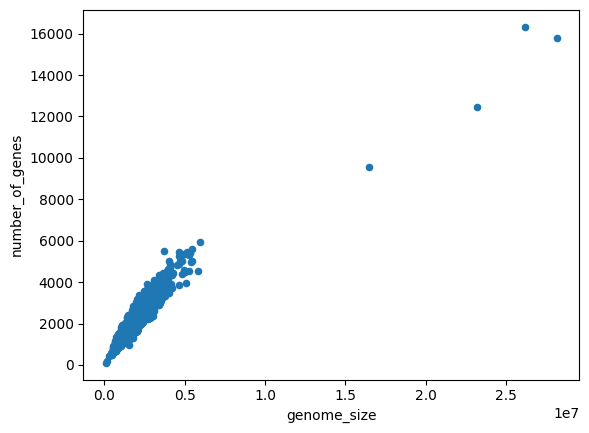

In [140]:
df_summary_stats.query("organism_type == 'prokaryotic'").plot(kind="scatter", x="genome_size", y="number_of_genes")

Text(0, 0.5, 'ratio')

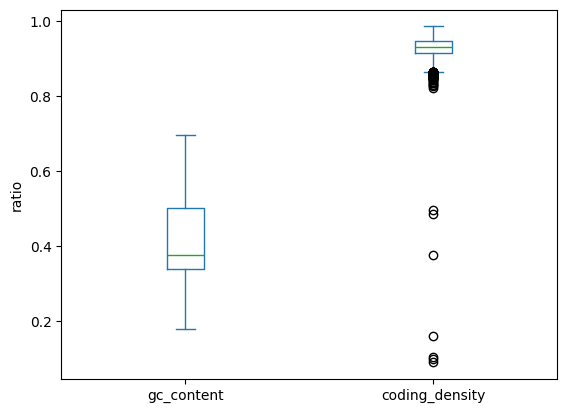

In [149]:
ax = df_summary_stats.query("organism_type == 'prokaryotic'")[["gc_content", "coding_density"]].plot(kind="box")
ax.set_ylabel("ratio")

In [145]:
df_summary_stats

,genome_size,coding_size,gc_content,number_of_genes,coding_density,organism_type
SRR7592212__BINETTE__P.1__bin_13,1601603,1417998,30.39,1540.0,0.885362,prokaryotic
SRR7592212__BINETTE__P.1__bin_2242,1154069,1046259,29.20,1178.0,0.906583,prokaryotic
SRR7592212__BINETTE__P.1__bin_2469,828978,734691,45.51,1130.0,0.886261,prokaryotic
SRR7592212__BINETTE__P.1__bin_2523,2815596,2479725,50.99,3214.0,0.880711,prokaryotic
SRR7592212__BINETTE__P.1__bin_2722,3130635,2847915,55.57,3356.0,0.909692,prokaryotic
...,...,...,...,...,...,...
SRR8361533__GENOMAD__Virus.5,34914,32172,46.55,53.0,0.921464,viral
SRR8361533__GENOMAD__Virus.6,3759,2889,46.45,4.0,0.768555,viral
SRR8361533__GENOMAD__Virus.7,27935,26244,37.19,35.0,0.939467,viral
SRR8361533__GENOMAD__Virus.8,5844,4995,38.02,7.0,0.854723,viral


In [41]:
%%bash
mkdir -p ../data/test/taxonomy/
mkdir -p ../data/test/pathway/

In [37]:
ls ../data

~$benchmarking.xlsx  benchmarking.xlsx  leviathan_index.OceanDNA_n-10.tar.gz


In [19]:
ls /home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJEB70438-Weinheimer_2023-PanamaMangroveReef/Analysis/leviathan_output/profiling/pathway/EPM_12A1/output/

feature_abundances.genome_clusters.tsv.gz
feature_abundances.genomes.tsv.gz
feature_prevalence-binary.genome_clusters.tsv.gz
feature_prevalence-binary.genomes.tsv.gz
feature_prevalence.genome_clusters.tsv.gz
feature_prevalence.genomes.tsv.gz
feature_prevalence-ratio.genome_clusters.tsv.gz
gene_abundances.genomes.tsv.gz
pathway_abundances.genome_clusters.tsv.gz
pathway_abundances.genomes.tsv.gz


In [3]:
# X = pd.read_parquet("/home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJNA621969-Nowinski_et_al_2019-PhytoplanktonBloom/Analysis/leviathan_output/profiling/DNA/pathway/feature_abundances.genomes.number_of_reads.parquet")
# X = (X > 0).astype(pd.SparseDtype(bool, fill_value=False)).T
# X.head()

id_genome  SRR7592212__BINETTE__P.1__bin_13                              \
id_feature                           K00052 K00053 K00058 K00075 K00088   
SRR7601383                             True   True  False   True   True   
SRR7608731                             True  False   True   True  False   
SRR7599849                             True  False  False  False   True   
SRR8361527                             True   True   True   True   True   
SRR7601262                             True   True   True   True   True   

id_genome                                      ...  \
id_feature K00099 K00116 K00145 K00174 K00175  ...   
SRR7601383  False  False   True   True   True  ...   
SRR7608731   True  False   True  False  False  ...   
SRR7599849  False  False  False  False  False  ...   
SRR8361527   True  False   True   True   True  ...   
SRR7601262  False  False   True   True   True  ...   

id_genome  SRR8361533__BINETTE__P.1__bin_9558                              \
id_feature                             K25152 K25153 K25656 K25706 K26061   
SRR7601383                              False  False  False   True   True   
SRR7608731                               True   True   True   True   True   
SRR7599849                              False  False  False  False  False   
SRR8361527                               True   True   True   True   True   
SRR7601262                               True   True   True   True   True   

id_genome                                      
id_feature K26937 K26939 K26958 K27078 K27683  
SRR7601383  False   True  False   True  False  
SRR7608731  False   True  False  False  False  
SRR7599849  False  False  False   True  False  
SRR8361527   True   True  False   True  False  
SRR7601262   True   True  False   True   True  

[5 rows x 2787327 columns]

In [ ]:
# %%time
# # from collections import OrderedDict
# # from tqdm import tqdm
# # output = OrderedDict()
# # for id_sample, data in tqdm(X.iterrows(), total=X.shape[1]):
# #     df = data.unstack().fillna(False)
# #     output[id_sample] = df.to_xarray()
# #     break


# # Convert the entire DataFrame to xarray
# ds = X.to_xarray()

# # Reshape the Dataset
# # da = ds.to_array(dim='samples').transpose('variable', ...)

# # If you need to fill NaN values with False
# # da = da.fillna(False)

In [4]:
ls /home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJNA621969-Nowinski_et_al_2019-PhytoplanktonBloom/Analysis/leviathan_output/profiling/DNA/pathway/

feature_abundances.genome_clusters.number_of_reads.parquet  SRR7601262/
feature_abundances.genome_clusters.number_of_reads.tsv.gz   SRR7601383/
feature_abundances.genome_clusters.tpm.parquet              SRR7601694/
feature_abundances.genome_clusters.tpm.tsv.gz               SRR7601699/
feature_abundances.genomes.number_of_reads.parquet          SRR7607748/
feature_abundances.genomes.number_of_reads.tsv.gz           SRR7607755/
feature_abundances.genomes.tpm.parquet                      SRR7607757/
feature_abundances.genomes.tpm.tsv.gz                       SRR7608008/
feature_prevalence.genomes.tsv.gz                           SRR7608010/
gene_abundances.genomes.number_of_reads.parquet             SRR7608017/
gene_abundances.genomes.number_of_reads.tsv.gz              SRR7608223/
gene_abundances.genomes.tpm.parquet                         SRR7608232/
gene_abundances.genomes.tpm.tsv.gz                          SRR7608423/
pathway_abundances.genome_clusters.coverage.parquet         SRR7